In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import minimize

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

# Make test problem

In [2]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)

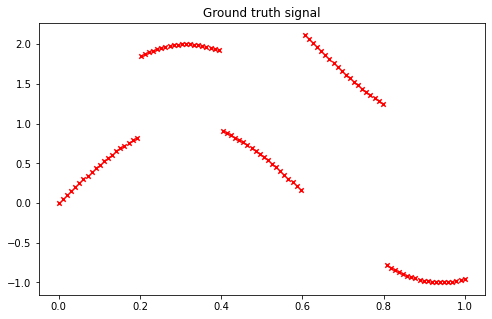

In [3]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [4]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [5]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

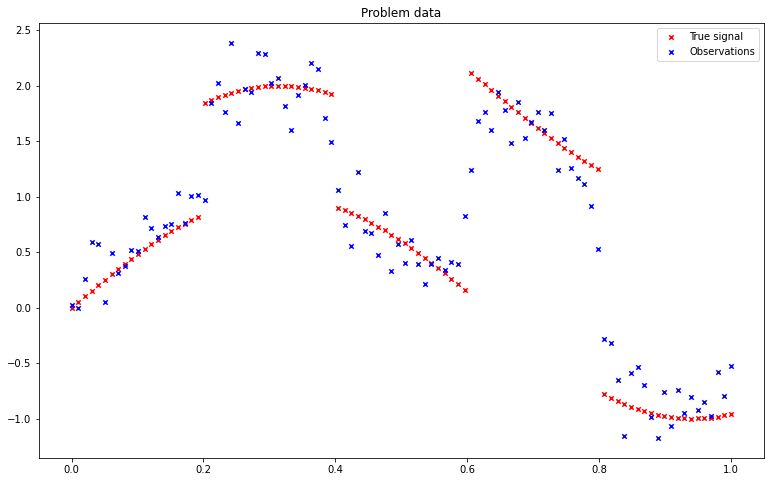

In [6]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.legend()
plt.title("Problem data")
plt.show()

# Reconstruction by multiple methods

In [7]:
# Methods so far: maximum expectation, L curve, discrepancy principle
from regtoolkit.parameter_selection import discrepancy_principle, maximum_expectation, lcurve, lcurve_corner

In [29]:
# Discrepancy principle
discrepancy_data = discrepancy_principle(F, R, y, noise_sigma, cg_maxits=1000)
print(f"Chosen regularization parameter lambda: {discrepancy_data['lambda']}")

Chosen regularization parameter lambda: 2.756756633350612


In [30]:
# Maximum expectation
me_data = maximum_expectation(F, R, y, n_iterations=10, trace_samples=50)
print(f"Chosen regularization parameter lambda: {me_data['lambda']}")

Chosen regularization parameter lambda: 0.32802618209891904


Chosen regularization parameter lambda: 0.4617930564051554


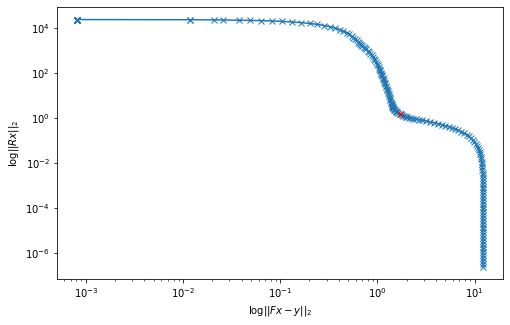

In [31]:
# Lcurve
lcurve_data = lcurve(F, R, y)
lcorner_data = lcurve_corner(lcurve_data)
print(f"Chosen regularization parameter lambda: {lcorner_data['lambda']}")

plt.figure(figsize=(8,5))
plt.loglog(lcurve_data["data_terms"], lcurve_data["reg_terms"], marker="x")
plt.loglog(lcorner_data["data_term"], lcorner_data["reg_term"], marker="x", color="red")
plt.xlabel(r"$\log || F x - y ||_2$")
plt.ylabel(r"$\log || R x ||_2$")
plt.show()

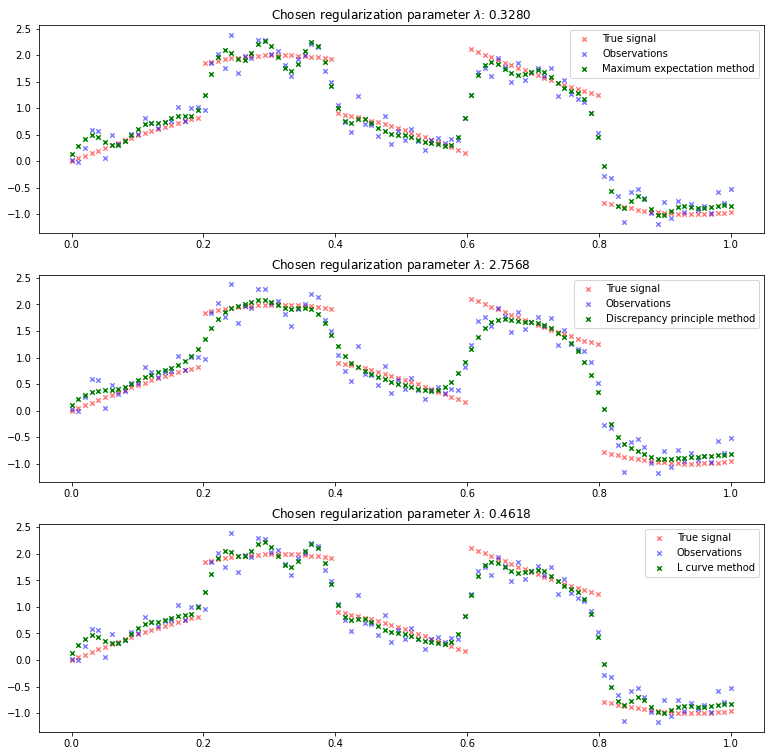

In [47]:
fig, axs = plt.subplots(3, 1, figsize=(13,13))

axs[0].scatter(dom, x, marker="x", color="red", s=20.0, label="True signal", alpha=0.5)
axs[0].scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations", alpha=0.5)
axs[0].scatter(dom, me_data["x_lambda"], marker="x", color="green", s=20.0, label="Maximum expectation method")
axs[0].set_title(f"Chosen regularization parameter $\lambda$: {me_data['lambda']:.4f}")
axs[0].legend()

axs[1].scatter(dom, x, marker="x", color="red", s=20.0, label="True signal", alpha=0.5)
axs[1].scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations", alpha=0.5)
axs[1].scatter(dom, discrepancy_data["x_lambda"], marker="x", color="green", s=20.0, label="Discrepancy principle method")
axs[1].set_title(f"Chosen regularization parameter $\lambda$: {discrepancy_data['lambda']:.4f}")
axs[1].legend()


axs[2].scatter(dom, x, marker="x", color="red", s=20.0, label="True signal", alpha=0.5)
axs[2].scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations", alpha=0.5)
axs[2].scatter(dom, lcorner_data["x_lambda"], marker="x", color="green", s=20.0, label="L curve method")
axs[2].set_title(f"Chosen regularization parameter $\lambda$: {lcorner_data['lambda']:.4f}")
axs[2].legend()

plt.show()